# Doppelpendel

Auf dem Übungszettel wurde das Doppelpendel analytisch behandelt. Allerdings sind die entsteheneden Bewegungsgleichungen nur unter Einschränkung (Kleinwinkelnäherung) analytisch lösbar.

In diesem Notebook wollen wir die analytische Lösung mit der numerischen vergleichen, um uns die Limitierung der Kleinwinkelnäherung zu verdeutlichen und das Verhalten des Pendels jenseits dieser Einschränkung zu erforschen.


## Bewegungsgleichungen

Die Bewegungsgleichungen sind auf dem Übungszettel gegeben

\begin{align}
\ddot{\theta_1} &= -\frac{m_2}{m_1 + m_2} \frac{l_2}{l_1} (\ddot{\theta_2} \cos(\theta_1 - \theta_2) + \dot{\theta_2^2} \sin(\theta_1 - \theta_2)) - \frac{g}{l_1} \sin(\theta_1)\\
\ddot{\theta_2} &= - \frac{l_1}{l_2} (\ddot{\theta_1} \cos(\theta_1 - \theta_2) - \dot{\theta_1^2} \sin(\theta_1 - \theta_2)) - \frac{g}{l_2} \sin(\theta_2)
\end{align}

Die Bewegungsgleichungen für die generalisierten Koordinaten $\theta_{1}$ und $\theta_{2}$ stellen ein nichtlineares System von zwei gekoppelten Differentialgleichungen dar, welches analytisch nicht lösbar ist. Es kann bei vier bekannten Anfangswerten ($\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2} $) mit numerischen Verfahren gelöst werden. Hierbei werden also die anfänglichen Auslenkungen (z.Bsp. ''30°'' und ''30°'') und die anfänglichen Geschwindigkeiten (z.Bsp. 0 $\frac{rad}{s}$) eingegeben und damit dann die Evolution des Pendels berechnet.

## Importieren der benötigten Bibliotheken

In [1]:
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML
from scipy.constants import pi,g  

import numpy as np
from numpy import sin, cos, sqrt

import scipy.integrate as integrate

## Eingabe unserer Systemgrößen und Startbedingungen

An dieser Stelle kann man mit den verschiedensten Werten experimentieren, um zu sehen ob unsere Numerische Integration von der Lösung mit Hilfe der Kleinwinkelnäherung abweicht.


In [42]:
# Anfangswerte für numerische Lösung: Winkel th und Winkelgeschwindikeiten w
th1 = np.pi/2
w1  = 1
th2 = 0
w2  = 1

# Längen und Massen für das Pendel
g = 9.81
l= l1 = l2 = 1
m1 = 1
m2 = 1

## Definition unserer Funktionen zum Lösen unserer Bewegunsgleichungen
### Kleinwinkelnäherung
Aus den in der Kleinwinkelnäherung gültigen Bewegunsgleichungen wurde gezeigt, dass folgender Ansatz die Differenzialgleichungen löst:

$\theta_1(t)=C1 \cos(\omega_1 t +\phi_1)+C_2 \cos(\omega_2t+\phi_2)$$$$$

$\theta_2(t)= - C1 \sqrt{\frac{1+\mu}{\mu}}\cos(\omega_1 t +\phi_1) + C_2 \sqrt{\frac{1+\mu}{\mu}} \cos(\omega_2t+\phi_2)$$$$$

Durch Lösen des Gleichungssystems für t=0 mit den gesetzten Startwinkeln lassen sich die Konstanten $C_1$ und $C_2$ bestimmen.

Außerdem können wir durch Einsetzen des Ansatzes in die Differentialgleichungen die charackteristischen Frequenzen bestimmen zu:

$$
\omega_{1,2}^2=\frac{g}{l}\cdot(1+\mu\pm\sqrt{(1+\mu)\cdot\mu})\, ,
$$

wobei $\mu=\frac{m_2}{m_1}$.


In [43]:
# Bestimmen der Konstanten
mu=m2/m1  # Verhältnis der Massen
mu_=sqrt((1+mu)/mu)
phi1=phi2=0 # Start-Phasen=0 

# Kleinwinkelnäherung charakteristische frequenzen
aw1=sqrt(g/l)*sqrt(1+mu+sqrt((1+mu)*mu))
aw2=sqrt(g/l)*sqrt(1+mu-sqrt((1+mu)*mu))

#Bestimmten der Vorfaktoren für die Bewegungsgleichung der Kleinwinkelnäherung
# np.radians()? # Umwandlung in Bogenmaß
C1 = np.radians(th1)/2-np.radians(th2)/(2*mu_)
C2 = np.radians(th1)/2+np.radians(th2)/(2*mu_)

In [44]:
# Funktion für die Bewegungsgleichung in der Kleinwinkelnäherung
# 
def theta_t(time):
    theta1 = C1 * np.cos(aw1 * time + phi1) + C2 * np.cos(aw2 * time + phi2)
    theta2 = - C1 * mu_ * np.cos(aw1 * time + phi1) + C2 * mu_ * np.cos(aw2 * time + phi2)
    return theta1, theta2

### System von Differentialgleichungen zur numerischen Integration

Durch Umformen unserer Bewegundgleichungen (ohne Kleinwinkelnäherung) können wir folgendes System von Differentialgleichugnen 1. Ordnung aufstellen:

\begin{align}
\dot\theta_1 &= \omega_1\\
\dot\omega_1 &= \ddot\theta_1 =\frac{ (m_2l_1\omega_1^2\cdot \sin(del)\cos(del) +
              m_2g\sin(\theta_2)\cos(del) +
               m_2l_2\omega_2^2\sin(del) -
               (m_1 + m_2)g\sin(\theta_1))}{den1}\,,
\end{align}
wobei
\begin{align}
del  &= \theta_2 - \theta_1\\
den1 &= (m_1 + m_2)l_1 - m_2l_1\cos^2(del)\,.
\end{align}

Analog:
\begin{align}
\dot\theta_2 &= \omega_2\\
\dot\omega_2 &= \ddot\theta_2=\frac{  (-m_2l_2\omega_2^2\sin(del)\cos(del) +
              (m_1 + m_2)g\sin(\theta_1)\cos(del) -
               (m_1 + m_2)l_1\omega_1^2\sin(del) -
               (m_1 + m_2)g\sin(\theta_2))}{den2}  \,,
\end{align}               
mit
$$
den2 = \frac{l_2}{l_1}\cdot den1\, .
$$

In [45]:
# Initialisieren der Anfangswerte für das numerische Lösungsverfahren
state = np.radians([th1, w1, th2, w2])

Der Zustand zur Zeit $t=0$ des Systems ist in `state` gespeichert und es gilt:

`state[0]` $\hat{=}\,\theta_1$\, `state[1]` $\hat{=}\,\omega_1$\, ....

Schreibe nun die Funktion, die die Ableitungen der jeweiligen Variablen berechnet. Das sollte so formuliert werden, dass man 

`dydx[0]` $\hat{=}\,\dot\theta_1$\, `dydx[1]` $\hat{=}\,\dot\omega_1$\, ....

schreiben kann.

Der erste Eintrag sollte also wie folgt gefüllt werden:
```[Python]
dydx[0] = state[1]
```

In [46]:
def derivs(state, t):
    
    dell = state[2] - state[0]
    den1 = (m1 + m2)*l1 - m2*l1*np.cos(dell)**2
    den2 = l2/l1 * den1
    
    dydx = np.zeros_like(state) 
    dydx[0] = state[1]          
    dydx[1] = 1/den1 * (m2*l1*state[1]**2*np.sin(dell)*np.cos(dell) + m2*g*np.sin(state[2])*np.cos(dell)\
            + m2*l2*state[3]**2*np.sin(dell) - (m1+m2)*g*np.sin(state[0]))
    dydx[2] = state[3]
    dydx[3] = 1/den2 * (-m2*l2*state[3]**2*np.sin(dell)*np.cos(dell) + (m1+m2)*g*np.sin(state[0])*np.cos(dell)\
            - (m1+m2)*l1*state[1]**2*np.sin(dell) - (m1+m2)*g*np.sin(state[2]))

    return dydx

## Lösen der Bewegungsgleichungen

Um unsere Bewegungsgleichungen zu integrieren verwenden wir hier die scipy funktion integrate.odeint.
Diese benötigt das Gleichungssystem, die Startbedingungen und das Zeitintervall und liefert uns ein array mit den errechneten Werten für Winkel und Winkelgeschwindigkeiten im Eingabeformat zurück.
(Im Kurs CWR im 4. Semester werden Algorithmen zum numerischen Integrieren von Differentialgleichungen genauer besprochen und selbst implementiert.)

Unsere analytische Lösung in der Kleinwinkelnäherung erhalten wir durch Aufrufen unserer vorher definierten Funktion theta_t.

In [47]:
dt = 0.02 
t = np.arange(0.0, 20, dt) # Array mit Zeitschritten von t=0....20s

# Numerische Lösung 
# Der Returnvalue ist ein array der gleichen Form wie state[]
# (hat 4 spalten -->eine für jeden winkel bzw winkelgeschwindigkeite zu jedem t) 
# Wir benutzen hier eine fertige Methode zum lösen von ode's, ähnlich dem Euler-Verfahren von vorherigen
# Zetteln
n_trj = integrate.odeint(derivs, state, t) 

# Analytische Lösung Kleinwinkelnäherung
# der Rückgabewert unserer Funktion sind jeweils die beiden Winkel
# Durch Übergabe unseres Zeitarrays erhalten wir je ein Array von Werten für theta1 und theta2
ath1,ath2= theta_t(t)


## Umwandeln in kartesische Koordinaten

In [48]:
# Funktion für die Umwandlung in kartesische Koordinaten

def kart_coord(th1,th2):
    x1 = l*np.sin(th1)
    y1 = -l*np.cos(th1)

    x2 = l*(np.sin(th1)+np.sin(th2))
    y2 = -l*(np.cos(th1)+np.cos(th2))
    
    return x1,y1,x2,y2

In [49]:
# Speichern der Kartesischen Koordinaten in arrays
# nx,ny --> numerische Lösung 
nx1,ny1,nx2,ny2 = kart_coord(n_trj[...,0],n_trj[...,2]) # die Formulierung y[:,0] schneidet die zweite Spalte aus unserem Array y
# ax,ay --> analytische Lösung
ax1,ay1,ax2,ay2 = kart_coord(ath1,ath2)                           

## Plotten der Bewegung

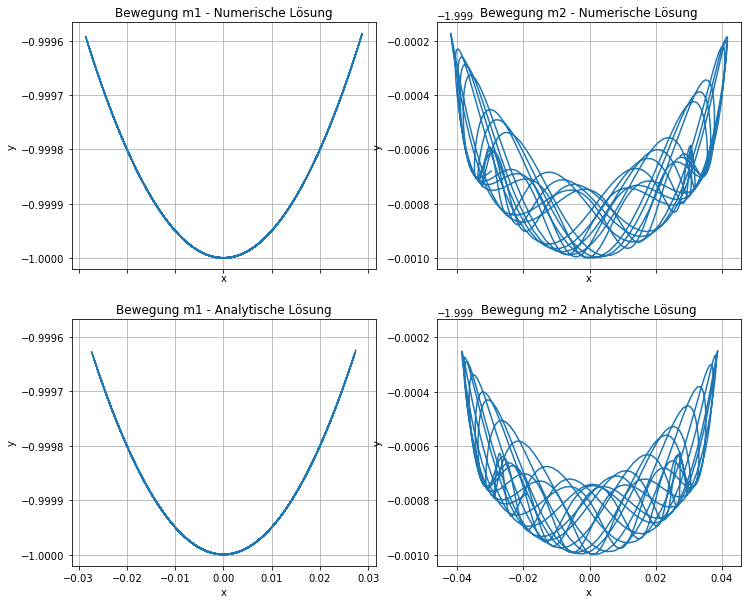

In [50]:
# Wir wollen unsere Bewegung als vier Subplots der selben Figure plotten
# dazu verwenden wir plt.subplots, welches uns ein Tupel zurück liefert
# fig kann man verwenden um Einstellungen auf "globaler" Ebene durchzuführen
# ax sind die Achsenobjekte und entsprechen unseren 4 Subplots

# Verwendet man die Optionen sharex/sharey
# werden in allen Plots die gleichen Achsenlimits gesetzt
fig, ax = plt.subplots(2,2, figsize=(12,10),sharex= 'col', sharey= 'col')

# Im folgenden werden für jeden Subplot die Werte und Beschriftungen etc. gesetzt
ax[0,0].plot(nx1, ny1)
ax[0,1].plot(nx2, ny2)
ax[1,0].plot(ax1, ay1)
ax[1,1].plot(ax2, ay2)
ax[0,0].set(xlabel='x', ylabel='y',title='Bewegung m1 - Numerische Lösung')
ax[0,1].set(xlabel='x', ylabel='y',title='Bewegung m2 - Numerische Lösung')
ax[1,0].set(xlabel='x', ylabel='y',title='Bewegung m1 - Analytische Lösung')
ax[1,1].set(xlabel='x', ylabel='y',title='Bewegung m2 - Analytische Lösung')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

plt.show()

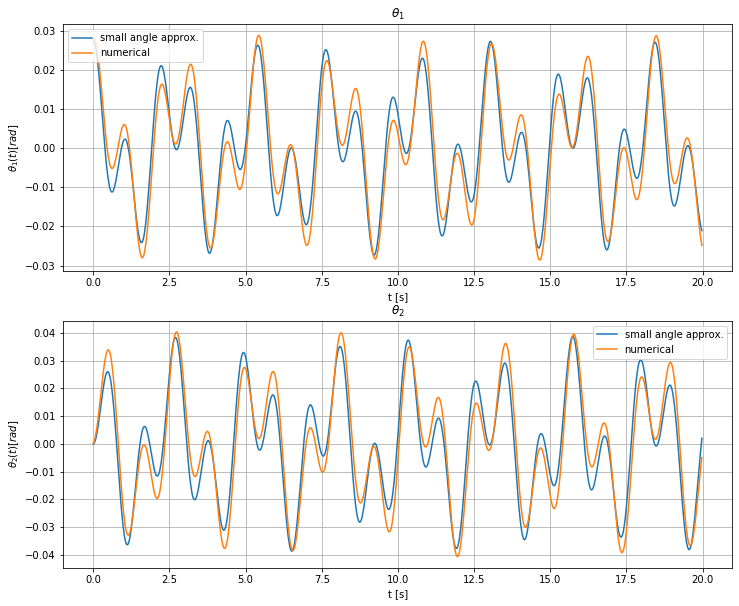

In [51]:
fig, ax = plt.subplots(2, figsize=(12,10))

ax[0].plot(t,ath1, label="small angle approx.")
ax[1].plot(t,ath2, label="small angle approx.")
ax[0].plot(t,n_trj[:, 0], label= "numerical")
ax[1].plot(t,n_trj[:, 2], label= "numerical")
ax[0].set(xlabel='t [s]', ylabel=r"$\theta_1(t) [rad]$",title=r"$\theta_1$")
ax[1].set(xlabel='t [s]', ylabel=r"$\theta_2(t) [rad]$",title=r"$\theta_2$")
for axes in ax:
    axes.legend()
    axes.grid()

plt.show()

## Erstellen einer Animation

Um eine Animation zu erstellen geht man im Grunde vor wie beim Erstellen von Plots. Allerdings wird nun eine Funktion benötigt, die den Plot zu jedem errechneten Zeitpunkt neu erstellt:

In [52]:
fig, ax= plt.subplots(1,2, figsize=(12,5),sharey=True) # Wir Deklarieren unseren Plot mit zwei nebeneinander liegenden Subplots (plt.subplot? für Hilfe)

# Eigenschaften der Subplots definieren:
# ax[0] soll unser chaotisches Pendel ausgeben und ax[1] unser Pendel in Kleinwinkelnäherung
ax[0].set_xlim((-3,3))
ax[0].set_ylim((-3,3))
ax[0].grid() 
ax[0].set(xlabel='x', ylabel='y',title='Pendelbewegung - Numerische Lösung')

ax[1].set(xlabel='x', ylabel='y',title='Pendelbewegund - Analytische Lösung')
ax[1].set_xlim((-3,3))
ax[1].set_ylim((-3,3))
ax[1].grid() 

line1, = ax[0].plot([], [], 'o-', lw=7) # erzeugt verbindungslinie
line2, = ax[1].plot([], [], 'o-', lw=7) # erzeugt verbindungslinie
time_template = 'time = %.1fs'       # erzeugt string template für zeit ausgabe
time_text = ax[0].text(0.05, 0.9, '', transform=ax[0].transAxes) # setzt position für Zeitangabe subplot ax[0]

def init():  # Initialisieren der Animation mit leerem Frame
    line1.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line1, line2, time_text


def animate(i): # Animationsfunktion. Erzeugt Plots zu jedem Zeitpunkt in t
    n_thisx = [0, nx1[i], nx2[i]] # Positionen Numerische Lösung
    n_thisy = [0, ny1[i], ny2[i]]

    a_thisx = [0, ax1[i], ax2[i]] # Positionen Analytische Lösung
    a_thisy = [0, ay1[i], ay2[i]]

    line1.set_data(n_thisx,n_thisy)   # Setzt Verbindunglinien (Pendelleine)
    line2.set_data(a_thisx,a_thisy) 
    time_text.set_text(time_template % (i*dt)) # Erzeugt Zeit-String

    return line1, line2, time_text 

# Erzeugt die Animation:
#animation.FuncAnimation?
ani = animation.FuncAnimation(fig, animate, np.arange(1, len(t)),interval=1000*dt, blit=True, init_func=init) 

# Verhindert Ausgabe des Plots (ohne Animation)
plt.close(ani._fig)

### Erstellen eines Videos

Die einzelnen Frames, die in der Variable ani gespeichert sind, werden nun in ein HTML5-video umgewandelt.
Dies kann eine Weile dauern. Nicht die Geduld verlieren. :)

In [66]:
print("I removed the animation otherwise the file would become too large")

I removed the animation otherwise the file would become too large


In [3]:
import numpy as np
x = np.linspace(0,0.2,100)
x

array([0.        , 0.0020202 , 0.0040404 , 0.00606061, 0.00808081,
       0.01010101, 0.01212121, 0.01414141, 0.01616162, 0.01818182,
       0.02020202, 0.02222222, 0.02424242, 0.02626263, 0.02828283,
       0.03030303, 0.03232323, 0.03434343, 0.03636364, 0.03838384,
       0.04040404, 0.04242424, 0.04444444, 0.04646465, 0.04848485,
       0.05050505, 0.05252525, 0.05454545, 0.05656566, 0.05858586,
       0.06060606, 0.06262626, 0.06464646, 0.06666667, 0.06868687,
       0.07070707, 0.07272727, 0.07474747, 0.07676768, 0.07878788,
       0.08080808, 0.08282828, 0.08484848, 0.08686869, 0.08888889,
       0.09090909, 0.09292929, 0.09494949, 0.0969697 , 0.0989899 ,
       0.1010101 , 0.1030303 , 0.10505051, 0.10707071, 0.10909091,
       0.11111111, 0.11313131, 0.11515152, 0.11717172, 0.11919192,
       0.12121212, 0.12323232, 0.12525253, 0.12727273, 0.12929293,
       0.13131313, 0.13333333, 0.13535354, 0.13737374, 0.13939394,
       0.14141414, 0.14343434, 0.14545455, 0.14747475, 0.14949